In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
from pymongo import MongoClient
from bson.objectid import ObjectId

import time,datetime
import os

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style

from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import keras

from sklearn import preprocessing

from copy import deepcopy
from IPython.display import clear_output

In [3]:
style.use('ggplot')

In [4]:
conn = MongoClient()
db = conn.Tracker
collection = [db.james]# db.db2, db.dn2, db.james, db.leo
clean_data = []
for col in collection:
    cursor = col.find({})
    df = pd.DataFrame(list(cursor))

In [5]:
df.replace('', np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)
df.isnull().sum().sum()

0

In [6]:
df['hr_value'] = df['hr_value'].astype(float)
df['o2_value'] = df['o2_value'].astype(float)
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['step_value'] = df['step_value'].astype(float)

In [7]:
df['moving_distance'] = np.abs(df.latitude.diff() * 111000) + np.abs(df.longitude.diff() * 110987)

In [8]:
df = df[(df['hr_value'] != 0)]

In [9]:
dfsteptotal = pd.DataFrame()
day = datetime.datetime.fromtimestamp(df['timestamp'].min()).strftime('%d')
month = datetime.datetime.fromtimestamp(df['timestamp'].min()).strftime('%m')
basetime = df['timestamp'].min()
while day != datetime.datetime.fromtimestamp(df['timestamp'].max()).strftime('%d') \
    or month != datetime.datetime.fromtimestamp(df['timestamp'].max()).strftime('%m'):
    df2 = pd.DataFrame({'month': [int(month)], 'day': [int(day)], 'morning':0, 'afternoon':0, 'evening':0})
    dfsteptotal = dfsteptotal.append(df2, ignore_index=True)
    basetime = (datetime.datetime.fromtimestamp(basetime) + datetime.timedelta(days=1)).timestamp()
    day = datetime.datetime.fromtimestamp(basetime).strftime('%d')
    month = datetime.datetime.fromtimestamp(basetime).strftime('%m')
df2 = pd.DataFrame({'month': [int(month)], 'day': [int(day)], 'morning':0, 'afternoon':0, 'evening':0})
dfsteptotal = dfsteptotal.append(df2, ignore_index=True)
dfsteptotal = dfsteptotal.set_index(['month', 'day'])
# dfsteptotal

In [10]:
# here I map between integer and the sting it's mean
timeslidemap = {0:'morning', 1:'afternoon', 2:'evening'}
basestamp = df['timestamp'][0]
endstamp = df['timestamp'][-1:].values[0]
# for num, row in df[:30000].iterrows():
while True:
    # here I write to devide time into 3 part where estimedevide will tell me basetime will be at
    estimedevide = int(int(datetime.datetime.fromtimestamp(basestamp).strftime('%H')) / 8)
#     print(estimedevide)
#     while estimedevide[0] != estimedevide[1]:
    hourend = 8*estimedevide + 7
    # know where the part the day is
#     print(int(datetime.datetime.fromtimestamp(basestamp).strftime('%H')), hourend)
    dfbetween = df.loc[df['timestamp'].between(basestamp,datetime.datetime.fromtimestamp(basestamp).replace(
                hour=hourend,minute=59,second=59).timestamp(), inclusive=True)]
    steps = dfbetween['step_value'].sum()
#     print(int(datetime.datetime.fromtimestamp(basestamp).strftime('%m')),
#             int(datetime.datetime.fromtimestamp(basestamp).strftime('%d')),
#                 timeslidemap[estimedevide])

    dfsteptotal.loc[[(int(datetime.datetime.fromtimestamp(basestamp).strftime('%m')),
                        int(datetime.datetime.fromtimestamp(basestamp).strftime('%d')))], 
                           [timeslidemap[estimedevide]]] += steps

    # These line are for debug whether steps are equal to dfsteptotal step's value
#     print('inspection', steps, '\n', dfsteptotal.loc[[(datetime.datetime.fromtimestamp(basestamp).isocalendar()[1] - 
#             (datetime.datetime.fromtimestamp(basestamp).isoweekday() < 7),
#                 datetime.datetime.fromtimestamp(basestamp).strftime('%w'))],[timeslidemap[estimedevide]]])
#     break
#     print(basestamp, endstamp)

    # next 8 hours of time
    basestamp = (datetime.datetime.fromtimestamp(basestamp) + datetime.timedelta(hours=8)).timestamp()
    if basestamp > endstamp:
        break
#     else:
#         print(datetime.datetime.fromtimestamp(basestamp) ,datetime.datetime.fromtimestamp(endstamp))

In [11]:
# dfsteptotal.loc[(dfsteptotal['morning'] == 0),['morning']]= int(dfsteptotal['morning'].mean())
dfsteptotal.loc[(dfsteptotal['afternoon'] == 0),['afternoon']]= int(dfsteptotal['afternoon'].mean())
dfsteptotal.loc[(dfsteptotal['evening'] == 0),['evening']]= int(dfsteptotal['evening'].mean())
# dfsteptotal[dfsteptotal['evening'] == 0]['evening'] = int(dfsteptotal['evening'].mean())
dfsteptotal['mComfort'] = 0
dfsteptotal['aComfort'] = 0
dfsteptotal['eComfort'] = 0 
dfsteptotal['mPrecp'] = 0
dfsteptotal['aPrecp'] = 0
dfsteptotal['ePrecp'] = 0

In [12]:
dfsteptotal

morning  afternoon  evening  mComfort  aComfort  eComfort  mPrecp  \
month day                                                                      
3     27       0.0     2966.0   2366.0         0         0         0       0   
      28       0.0     2104.0   1664.0         0         0         0       0   
      29       0.0     2966.0   1664.0         0         0         0       0   
      30       0.0     1878.0     73.0         0         0         0       0   
      31     320.0      454.0    367.0         0         0         0       0   
4     1        0.0     6587.0   2145.0         0         0         0       0   
      2      248.0     3702.0   1444.0         0         0         0       0   
      3        0.0     1964.0   3793.0         0         0         0       0   
      4      499.0     3090.0   1854.0         0         0         0       0   
      5      318.0     2084.0   1471.0         0         0         0       0   
      6        0.0     2051.0   1353.0         0         0         0       0   
      7      692.0     2506.0   5639.0         0         0         0       0   
      8      289.0     3269.0   1581.0         0         0         0       0   
      9        0.0      229.0   3903.0         0         0         0       0   
      10       0.0     3989.0    744.0         0         0         0       0   
      11       0.0     1879.0    434.0         0         0         0       0   
      12      91.0     3568.0    480.0         0         0         0       0   
      13    1391.0     3726.0    256.0         0         0         0       0   
      14     229.0     4427.0   1918.0         0         0         0       0   
      15    1111.0     7476.0   2890.0         0         0         0       0   
      16       0.0     1629.0   2850.0         0         0         0       0   
      17     298.0     4275.0   2433.0         0         0         0       0   
      18     342.0     4088.0   2814.0         0         0         0       0   
      19     327.0     2870.0   1638.0         0         0         0       0   
      20      53.0     5175.0   1561.0         0         0         0       0   
      21     300.0     2437.0    935.0         0         0         0       0   
      22     503.0     4625.0   1664.0         0         0         0       0   

           aPrecp  ePrecp  
month day                  
3     27        0       0  
      28        0       0  
      29        0       0  
      30        0       0  
      31        0       0  
4     1         0       0  
      2         0       0  
      3         0       0  
      4         0       0  
      5         0       0  
      6         0       0  
      7         0       0  
      8         0       0  
      9         0       0  
      10        0       0  
      11        0       0  
      12        0       0  
      13        0       0  
      14        0       0  
      15        0       0  
      16        0       0  
      17        0       0  
      18        0       0  
      19        0       0  
      20        0       0  
      21        0       0  
      22        0       0

In [13]:
# add wether 
coding = 'utf-8'
table = pd.DataFrame()
for index, row in dfsteptotal.iterrows():
    try:
        # parsing part
        date = datetime.date(2019,index[0],index[1])
        dateStr = date.strftime('%Y-%m-%d')
        url = 'https://e-service.cwb.gov.tw/HistoryDataQuery/DayDataController.do?command=viewMain&station=C0AC60'+ \
            '&stname=%25E4%25B8%2589%25E5%25B3%25BD&datepicker=' + dateStr
        table = pd.read_html(url,encoding=coding,index_col=0,header=None,flavor='bs4')[1]
        # start dataprocess
        table.replace('/', np.nan, inplace=True)
        table.replace('X', np.nan, inplace=True)  
        table.fillna(method='ffill', inplace=True)
        table.index -= 1
        dfoneday = pd.DataFrame()
        # the table data need to reshape and turn to a variable
        T = table['temperature'].values.reshape(len(table['temperature'].values)).astype('float')
        RH = table['RH'].values.reshape(len(table['RH'].values)).astype('float')
        dfoneday['comfort'] = T - 0.55 *(1-RH/100)*(T - 14)
        dfoneday['Precp'] = table['Precp']['降水量(mm)']
        bins = [0,11,16,20,27,31,60]
        labels=[0,1,2,3,4,5]
        dfoneday['bins'] = pd.cut(dfoneday['comfort'], bins=bins, labels=labels, include_lowest=True)
        # mComfort aComfort eComfort mPrecp aPrecp ePrecp
        dfsteptotal.loc[[index], ['mComfort']] = dfoneday['comfort'][:8].mean()
        dfsteptotal.loc[[index], ['aComfort']] = dfoneday['comfort'][8:16].mean()
        dfsteptotal.loc[[index], ['eComfort']] = dfoneday['comfort'][16:24].mean()
        dfoneday['Precp'].astype(float)
        dfsteptotal.loc[[index], ['mPrecp']] = dfoneday['Precp'][:8].astype(float).sum()
        dfsteptotal.loc[[index], ['aPrecp']] = dfoneday['Precp'][8:16].astype(float).sum()
        dfsteptotal.loc[[index], ['ePrecp']] = dfoneday['Precp'][16:24].astype(float).sum()
    except Exception as e:
        if str(e) == "could not convert string to float: '...'":
            print('some data are not yet ready')
            break

some data are not yet ready


In [14]:
dfsteptotal

morning  afternoon  evening   mComfort   aComfort   eComfort  \
month day                                                                 
3     27       0.0     2966.0   2366.0  17.841256  23.257875  21.589019   
      28       0.0     2104.0   1664.0  20.830862  25.678481  24.105356   
      29       0.0     2966.0   1664.0  22.266781  23.802212  21.383894   
      30       0.0     1878.0     73.0  18.326075  21.808613  20.039981   
      31     320.0      454.0    367.0  18.860650  19.223331  17.091438   
4     1        0.0     6587.0   2145.0  15.530887  16.550800  16.420938   
      2      248.0     3702.0   1444.0  17.566713  20.132119  19.769588   
      3        0.0     1964.0   3793.0  18.636856  20.153469  20.663150   
      4      499.0     3090.0   1854.0  20.526406  24.160737  20.846312   
      5      318.0     2084.0   1471.0  19.924379  21.695000  19.779444   
      6        0.0     2051.0   1353.0  18.114744  22.943481  21.675069   
      7      692.0     2506.0   5639.0  20.240488  24.874769  24.066000   
      8      289.0     3269.0   1581.0  21.973288  25.583881  24.354125   
      9        0.0      229.0   3903.0  22.188456  26.095569  25.999975   
      10       0.0     3989.0    744.0  23.644756  25.687950  21.432000   
      11       0.0     1879.0    434.0  20.633781  22.485700  18.027725   
      12      91.0     3568.0    480.0  17.653537  19.631869  18.866875   
      13    1391.0     3726.0    256.0  18.761169  22.035062  20.663150   
      14     229.0     4427.0   1918.0  20.600994  24.039919  20.609475   
      15    1111.0     7476.0   2890.0  19.140912  19.850719  18.736356   
      16       0.0     1629.0   2850.0  18.263919  19.109244  18.910344   
      17     298.0     4275.0   2433.0  18.922775  22.934875  20.331169   
      18     342.0     4088.0   2814.0  19.591437  24.753725  23.315006   
      19     327.0     2870.0   1638.0  21.844119  24.608169  22.739169   
      20      53.0     5175.0   1561.0  21.884964  25.296044  23.915606   
      21     300.0     2437.0    935.0  22.614856  26.022481  25.104875   
      22     503.0     4625.0   1664.0   0.000000   0.000000   0.000000   

           mPrecp  aPrecp  ePrecp  
month day                          
3     27      0.0     0.0     0.0  
      28      0.0     0.0     0.0  
      29      0.0     0.0    13.0  
      30      3.5     0.0     0.0  
      31      0.5     0.0     0.0  
4     1       4.5     0.0     0.5  
      2       0.0     0.0     0.0  
      3       0.0     0.0     0.0  
      4       0.0     0.0     0.0  
      5       0.0     0.0     0.0  
      6       0.0     0.0     0.0  
      7       0.0     0.0     0.0  
      8       0.0     0.0     0.0  
      9       0.0     0.0     0.0  
      10      0.0     0.0     0.0  
      11      0.0     1.5    19.5  
      12      0.0     0.0     0.0  
      13      0.5     1.5     0.5  
      14      0.0     0.0     1.5  
      15      0.0     0.0     2.0  
      16     20.5    18.0     2.0  
      17      0.0     0.0     0.0  
      18      0.0     0.0     0.0  
      19      3.0     0.5    12.5  
      20      0.0     0.0     5.0  
      21     38.5     0.5     0.5  
      22      0.0     0.0     0.0

In [128]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences[0])):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences[0])-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequences[0][i:end_ix].reshape(len(sequences[0][i:end_ix]),1) 
        seq_x = np.append(seq_x, sequences[1][i:end_ix].reshape(len(sequences[1][i:end_ix]),1), axis=1)
        seq_x = np.append(seq_x, sequences[2][i:end_ix].reshape(len(sequences[2][i:end_ix]),1), axis=1)
        seq_y1, seq_y2 , seq_y3 =  sequences[0][end_ix] ,sequences[1][end_ix], sequences[2][end_ix]
        X.append(seq_x)
        y.append([seq_y1,seq_y2,seq_y3])
    return np.array(X), np.array(y)

In [130]:
dataset = np.array([morning, afternoon, evening])
n_steps = 2
X, y = split_sequences(dataset, n_steps)
for i in range(10):
    print(X[i], y[i])

[[   0. 2966. 2366.]
 [   0. 2104. 1664.]] [   0. 2966. 1664.]
[[   0. 2104. 1664.]
 [   0. 2966. 1664.]] [   0. 1878.   73.]
[[   0. 2966. 1664.]
 [   0. 1878.   73.]] [320. 454. 367.]
[[   0. 1878.   73.]
 [ 320.  454.  367.]] [   0. 6587. 2145.]
[[ 320.  454.  367.]
 [   0. 6587. 2145.]] [ 248. 3702. 1444.]
[[   0. 6587. 2145.]
 [ 248. 3702. 1444.]] [   0. 1964. 3793.]
[[ 248. 3702. 1444.]
 [   0. 1964. 3793.]] [ 499. 3090. 1854.]
[[   0. 1964. 3793.]
 [ 499. 3090. 1854.]] [ 318. 2084. 1471.]
[[ 499. 3090. 1854.]
 [ 318. 2084. 1471.]] [   0. 2051. 1353.]
[[ 318. 2084. 1471.]
 [   0. 2051. 1353.]] [ 692. 2506. 5639.]


In [16]:
# this split will predict next value
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
dataset = np.array([in_seq1, in_seq2])
n_steps = 3
X, y = split_sequences(dataset, n_steps)
for i in range(len(X)):
    print(X[i], y[i])

IndexError: index 2 is out of bounds for axis 0 with size 2

In [131]:
morning = dfsteptotal['morning'][:-1].values
afternoon = dfsteptotal['afternoon'][:-1].values
evening = dfsteptotal['evening'][:-1].values

mComfort = dfsteptotal['mComfort'][:-1].values
aComfort = dfsteptotal['aComfort'][:-1].values
eComfort = dfsteptotal['eComfort'][:-1].values

mPrecp = dfsteptotal['mPrecp'][:-1].values
aPrecp = dfsteptotal['aPrecp'][:-1].values
ePrecp = dfsteptotal['ePrecp'][:-1].values

In [132]:
dataset = np.array([morning, afternoon, evening])
n_steps = 2
X, y = split_sequences(dataset, n_steps)
for i in range(4):
    print(X[i], y[i])

[[   0. 2966. 2366.]
 [   0. 2104. 1664.]] [   0. 2966. 1664.]
[[   0. 2104. 1664.]
 [   0. 2966. 1664.]] [   0. 1878.   73.]
[[   0. 2966. 1664.]
 [   0. 1878.   73.]] [320. 454. 367.]
[[   0. 1878.   73.]
 [ 320.  454.  367.]] [   0. 6587. 2145.]


In [19]:
# n_features = 3
# model = Sequential()
# model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(50 ,activation='relu'))
# model.add(Dense(n_features))
# model.compile(optimizer='adam', loss='mse')
# model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2, 64)             448       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3250      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 153       
Total params: 3,851
Trainable params: 3,851
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X, y, epochs=150, verbose=0, batch_size=128, validation_split=0.2)

<IPython.core.display.Javascript object>


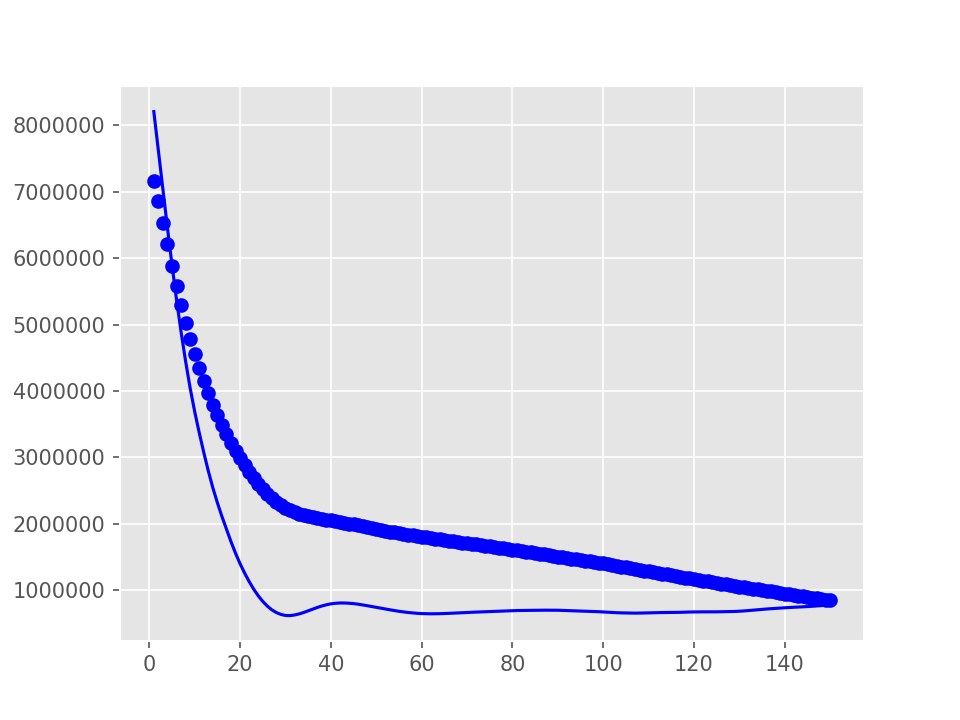

In [21]:
%matplotlib notebook
loss = history.history['loss']
val_loss = history.history['val_loss']
# acc = history.history['acc']
# val_acc = history.history['val_acc']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.show()

In [133]:
n_features = 3
model = Sequential()
model.add(keras.layers.LSTM(100,activation='relu', return_sequences=True,input_shape=(n_steps, n_features)))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(50 ,activation='relu'))
model.add(keras.layers.LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 2, 100)            41600     
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 303       
Total params: 122,303
Trainable params: 122,303
Non-trainable params: 0
_________________________________________________________________


In [134]:
history = model.fit(X, y, epochs=500, verbose=0, batch_size=128, validation_split=0.2)

<IPython.core.display.Javascript object>


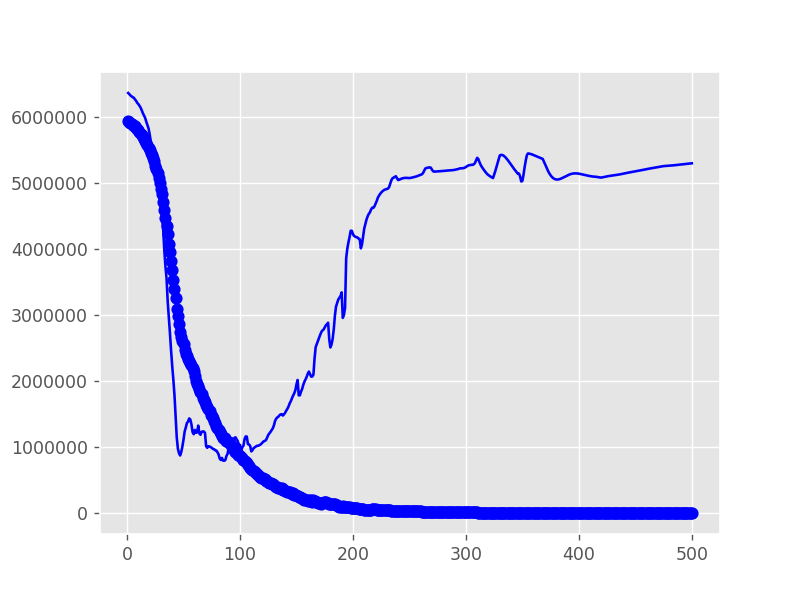

In [135]:
%matplotlib notebook
loss = history.history['loss']
val_loss = history.history['val_loss']
# acc = history.history['acc']
# val_acc = history.history['val_acc']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.show()